<a href="https://colab.research.google.com/github/ShuaimingJing/540IP/blob/main/Assignment9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #9
### Name: Shuaiming Jing

### Referenced material: https://colab.research.google.com/github/TransformerLensOrg/TransformerLens/blob/main/demos/Grokking_Demo.ipynb
https://www.youtube.com/watch?v=ob4vuiqG2Go

# What is grokking

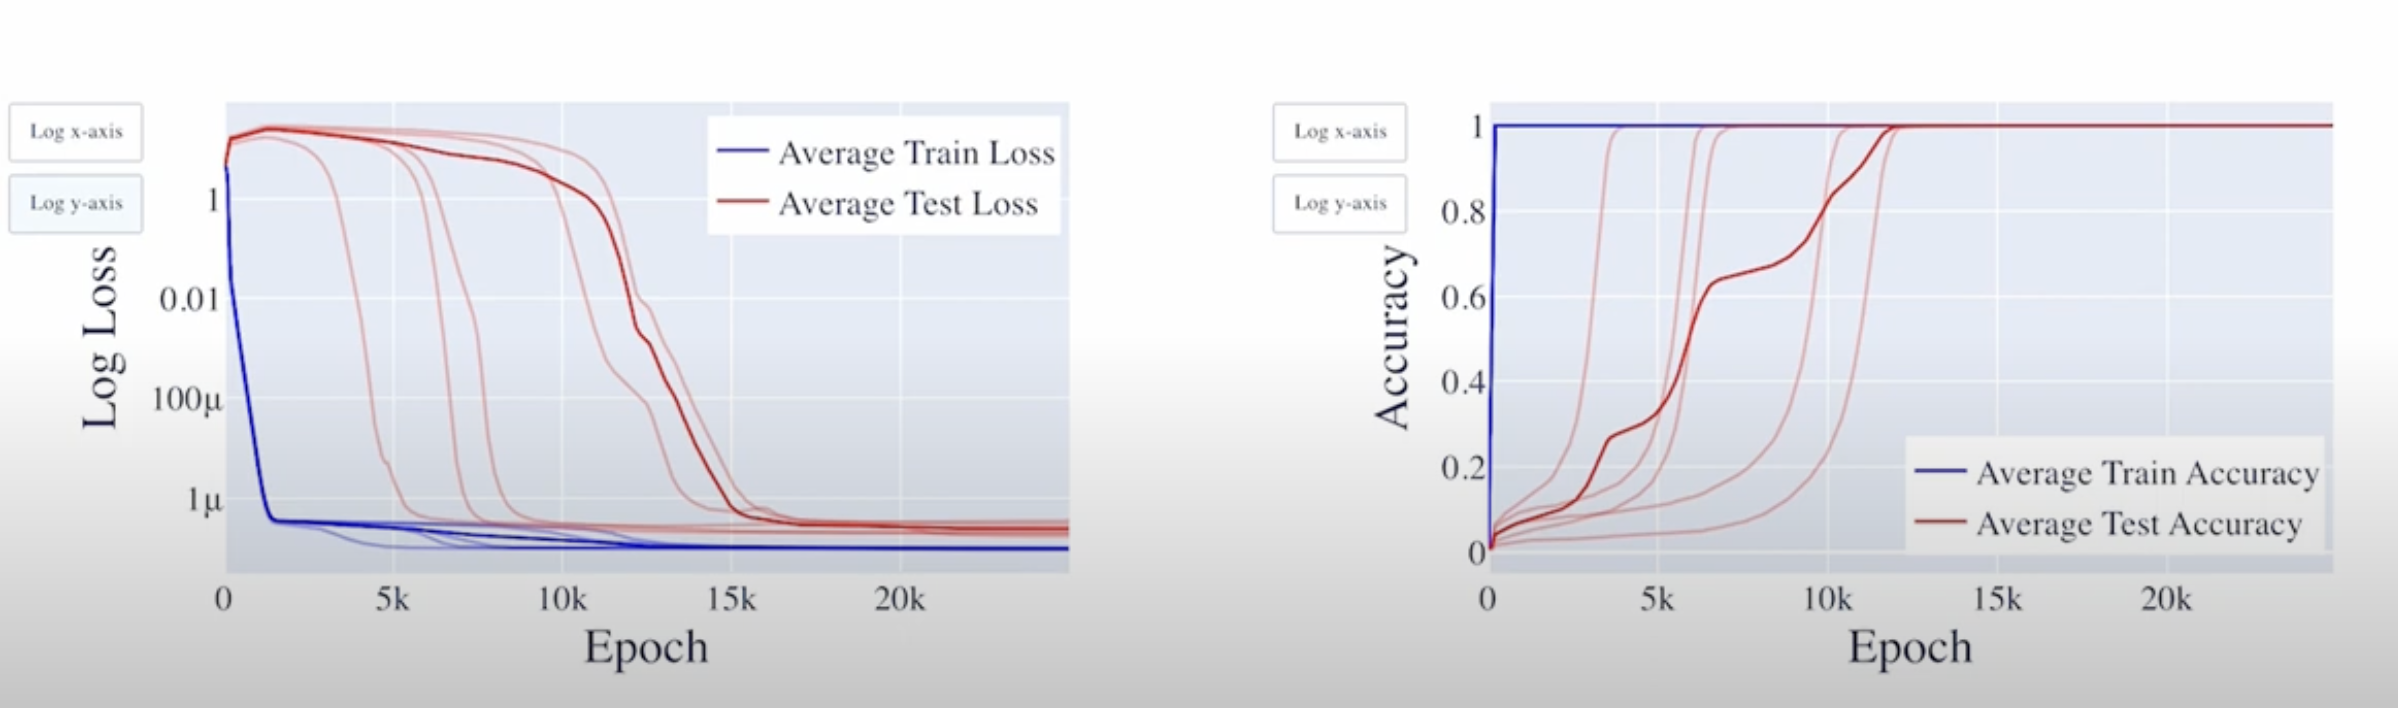

Grokking is a really interesting phenomenon. The above plots show how it works. When you start training a model, the model does what we expected. The traning loss decreases dramtically at first few epochs, but the test loss decreases slowly, meaning the model is learning to memorize the training data, but haven't started generalizing yet. If you keep training the model for an extreme long time, it looks like the model suddenly figures out what the right answer is after memorizing so much data.The training loss is not decreasing too much anymore, which means the model has already memorized most training data successfully. The test loss decreases dramtically, which means the model successfully learns the pattern among the memorized data, and know how to generalize on unsee data.

# Setup
(No need to read)

In [ ]:
TRAIN_MODEL = True

In [ ]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
import os

DEVELOPMENT_MODE = True
IN_GITHUB = os.getenv("GITHUB_ACTIONS") == "true"
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")

    # PySvelte is an unmaintained visualization library, use it as a backup if circuitsvis isn't working
    # # Install another version of node that makes PySvelte work way faster
    # !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    # %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

if IN_COLAB or IN_GITHUB:
    %pip install transformer_lens
    %pip install circuitsvis

Running as a Colab notebook
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.6/176.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.0
    Uninstalling typeguard-4.4.0:
      Successfully uninstalled typeguard-4.4.0
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0


In [ ]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
if IN_COLAB or not DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

Using renderer: colab


In [ ]:
pio.templates['plotly'].layout.xaxis.title.font.size = 20
pio.templates['plotly'].layout.yaxis.title.font.size = 20
pio.templates['plotly'].layout.title.font.size = 30

In [ ]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import os
import tqdm.auto as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [ ]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache


device = "cuda" if torch.cuda.is_available() else "cpu"

Plotting helper functions:

In [ ]:
def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

In [ ]:
# Define the location to save the model, using a relative path
PTH_LOCATION = "workspace/_scratch/grokking_demo.pth"

# Create the directory if it does not exist
os.makedirs(Path(PTH_LOCATION).parent, exist_ok=True)

# Model Training

## Config

In [ ]:
p = 113
frac_train = 0.3

# Optimizer config
lr = 1e-3
wd = 1.
betas = (0.9, 0.98)

num_epochs = 25000
checkpoint_every = 100

DATA_SEED = 598

## Define Task
* Define modular addition
* Define the dataset & labels



Input format:
|a|b|=|

In [ ]:
a_vector = einops.repeat(torch.arange(p), "i -> (i j)", j=p)
b_vector = einops.repeat(torch.arange(p), "j -> (i j)", i=p)
equals_vector = einops.repeat(torch.tensor(113), " -> (i j)", i=p, j=p)


In [ ]:
dataset = torch.stack([a_vector, b_vector, equals_vector], dim=1).to(device)
print(dataset[:5])
print(dataset.shape)

tensor([[  0,   0, 113],
        [  0,   1, 113],
        [  0,   2, 113],
        [  0,   3, 113],
        [  0,   4, 113]], device='cuda:0')
torch.Size([12769, 3])


In [ ]:
labels = (dataset[:, 0] + dataset[:, 1]) % p
print(labels.shape)
print(labels[:5])

torch.Size([12769])
tensor([0, 1, 2, 3, 4], device='cuda:0')


Convert this to a train + test set - 30% in the training set

In [ ]:
torch.manual_seed(DATA_SEED)
indices = torch.randperm(p*p)
cutoff = int(p*p*frac_train)
train_indices = indices[:cutoff]
test_indices = indices[cutoff:]

train_data = dataset[train_indices]
train_labels = labels[train_indices]
test_data = dataset[test_indices]
test_labels = labels[test_indices]
print(train_data[:5])
print(train_labels[:5])
print(train_data.shape)
print(test_data[:5])
print(test_labels[:5])
print(test_data.shape)

tensor([[ 21,  31, 113],
        [ 30,  98, 113],
        [ 47,  10, 113],
        [ 86,  21, 113],
        [ 99,  83, 113]], device='cuda:0')
tensor([ 52,  15,  57, 107,  69], device='cuda:0')
torch.Size([3830, 3])
tensor([[ 43,  40, 113],
        [ 31,  42, 113],
        [ 39,  63, 113],
        [ 35,  61, 113],
        [112, 102, 113]], device='cuda:0')
tensor([ 83,  73, 102,  96, 101], device='cuda:0')
torch.Size([8939, 3])


#### Another interesting finding: Typically, we use 80% as training data and 20% as test data, but why in this demo the author uses 70%/30% when doing train test split?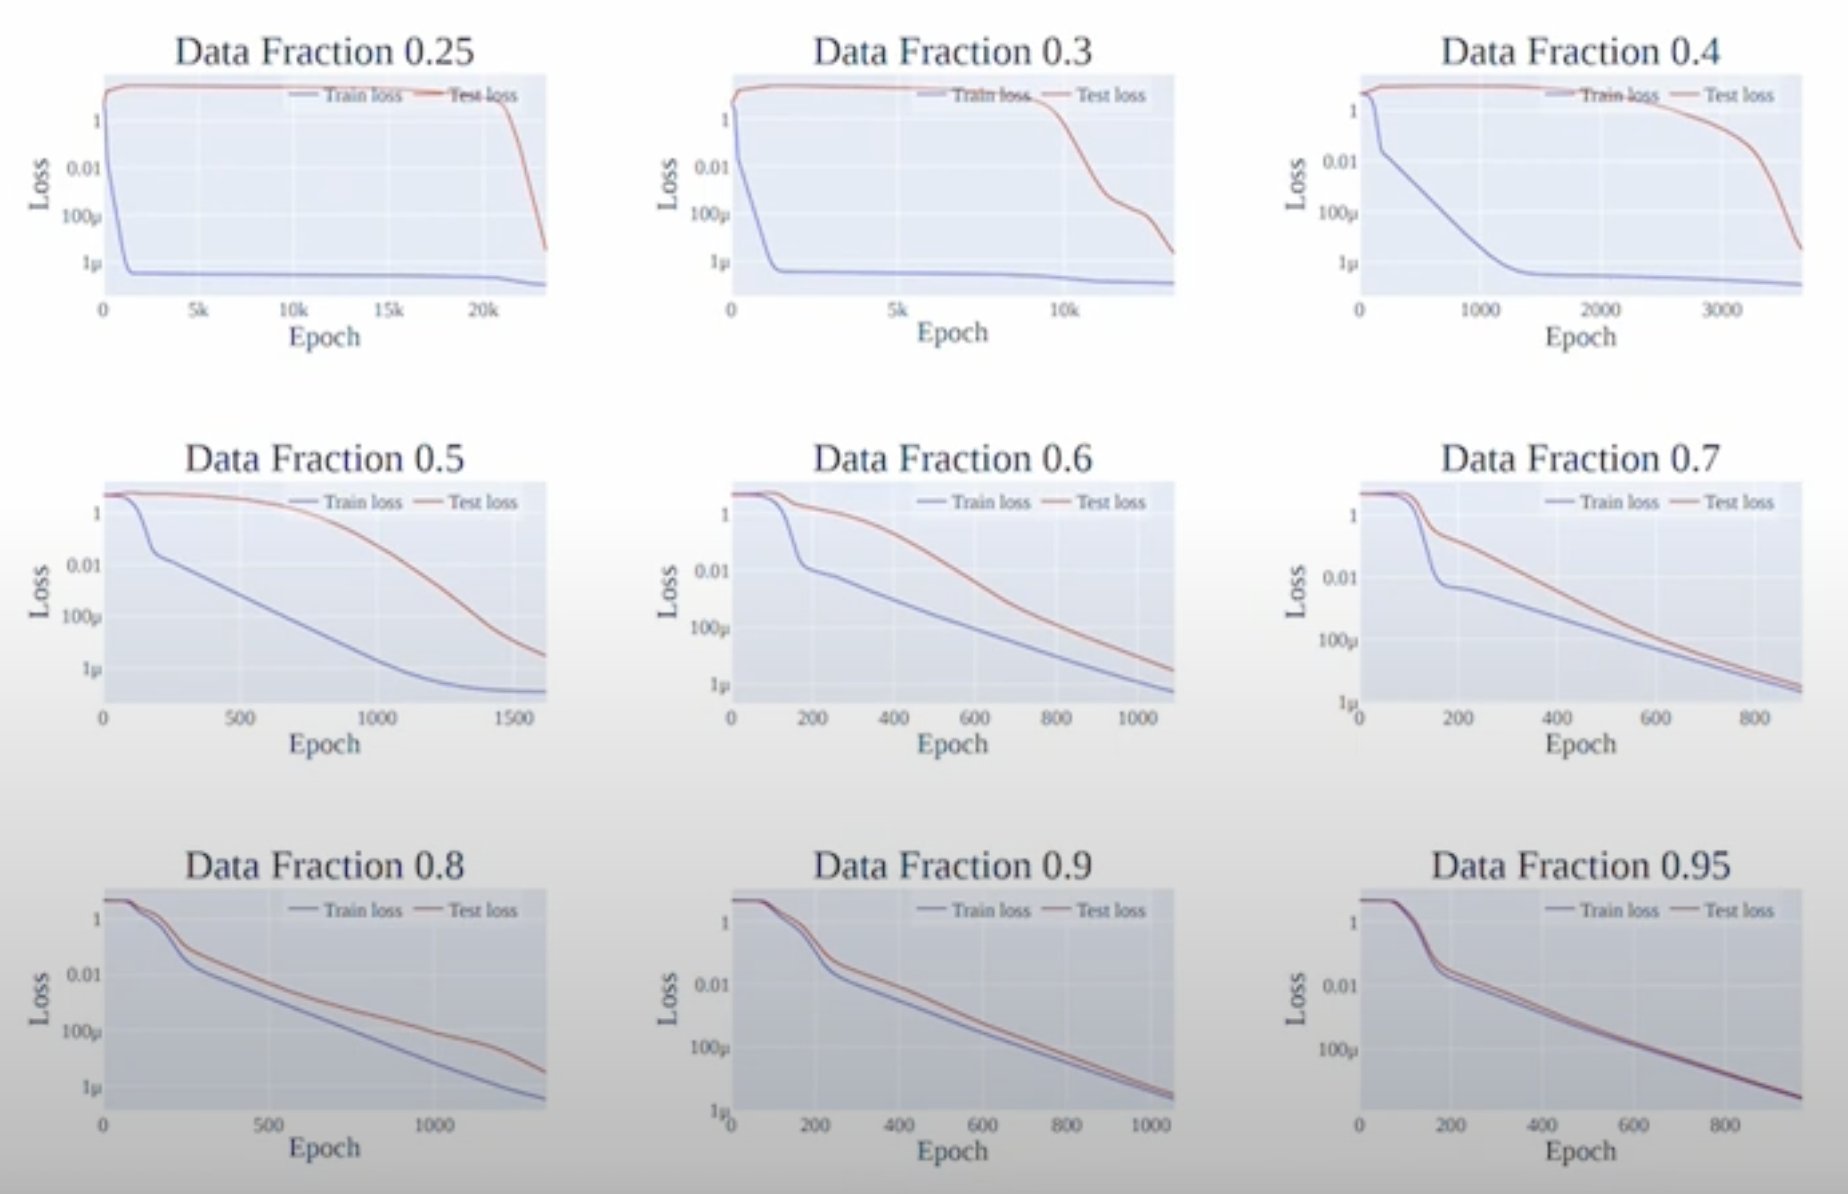

(The above image is from youtube video in the reference material) 70%/30% is the point where we can see obvious grokking phenomenon and it doesn't take a long time. The above plot shows the training and test loss under different data splitting ratios. For 0.25, the model achieves grokking 20k epochs, which is much slower than 0.3, and for higher value, the model doesn't show a strong grokking phenomenon, some may even not exist for much higher splitting ratios.

## Define Model

In [ ]:

cfg = HookedTransformerConfig(
    n_layers = 1,
    n_heads = 4,
    d_model = 128,
    d_head = 32,
    d_mlp = 512,
    act_fn = "relu",
    normalization_type=None,
    d_vocab=p+1,
    d_vocab_out=p,
    n_ctx=3,
    init_weights=True,
    device=device,
    seed = 999,
)

In [ ]:
model = HookedTransformer(cfg)

Disable the biases, as we don't need them for this task and it makes things easier to interpret.

In [ ]:
for name, param in model.named_parameters():
    if "b_" in name:
        param.requires_grad = False


## Define Optimizer + Loss

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd, betas=betas)

In [ ]:
def loss_fn(logits, labels):
    if len(logits.shape)==3:
        logits = logits[:, -1]
    logits = logits.to(torch.float64)
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels[:, None])[:, 0]
    return -correct_log_probs.mean()
train_logits = model(train_data)
train_loss = loss_fn(train_logits, train_labels)
print(train_loss)
test_logits = model(test_data)
test_loss = loss_fn(test_logits, test_labels)
print(test_loss)

tensor(4.7359, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(4.7330, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)


In [ ]:
print("Uniform loss:")
print(np.log(p))

Uniform loss:
4.727387818712341


## Actually Train

**Weird Decision:** Training the model with full batch training rather than stochastic gradient descent. We do this so to make training smoother and reduce the number of slingshots.

In [ ]:
train_losses = []
test_losses = []
model_checkpoints = []
checkpoint_epochs = []
if TRAIN_MODEL:
    for epoch in tqdm.tqdm(range(num_epochs)):
        train_logits = model(train_data)
        train_loss = loss_fn(train_logits, train_labels)
        train_loss.backward()
        train_losses.append(train_loss.item())

        optimizer.step()
        optimizer.zero_grad()

        with torch.inference_mode():
            test_logits = model(test_data)
            test_loss = loss_fn(test_logits, test_labels)
            test_losses.append(test_loss.item())

        if ((epoch+1)%checkpoint_every)==0:
            checkpoint_epochs.append(epoch)
            model_checkpoints.append(copy.deepcopy(model.state_dict()))
            print(f"Epoch {epoch} Train Loss {train_loss.item()} Test Loss {test_loss.item()}")

  0%|          | 0/25000 [00:00<?, ?it/s]

Epoch 99 Train Loss 2.928639568615323 Test Loss 7.652201573094078
Epoch 199 Train Loss 0.030468690992160735 Test Loss 20.00884351615092
Epoch 299 Train Loss 0.009583219552879113 Test Loss 20.70870496911377
Epoch 399 Train Loss 0.003083786619192272 Test Loss 21.869525798279845
Epoch 499 Train Loss 0.0010207464174321968 Test Loss 23.142360434722786
Epoch 599 Train Loss 0.00034403393832221365 Test Loss 24.473146963708714
Epoch 699 Train Loss 0.00011753023439546449 Test Loss 25.817617483219617
Epoch 799 Train Loss 4.0779760993843106e-05 Test Loss 27.168161553912448
Epoch 899 Train Loss 1.445250381492017e-05 Test Loss 28.495219908141358
Epoch 999 Train Loss 5.333542844484826e-06 Test Loss 29.76539416792693
Epoch 1099 Train Loss 2.128811982136302e-06 Test Loss 30.907725627447277
Epoch 1199 Train Loss 9.833050279802283e-07 Test Loss 31.800972835492235
Epoch 1299 Train Loss 5.617065650731848e-07 Test Loss 32.34186617249805
Epoch 1399 Train Loss 4.073082800608483e-07 Test Loss 32.50008996505985

In [ ]:
torch.save(
    {
        "model":model.state_dict(),
        "config": model.cfg,
        "checkpoints": model_checkpoints,
        "checkpoint_epochs": checkpoint_epochs,
        "test_losses": test_losses,
        "train_losses": train_losses,
        "train_indices": train_indices,
        "test_indices": test_indices,
    },
    PTH_LOCATION)

In [ ]:
if not TRAIN_MODEL:
    cached_data = torch.load(PTH_LOCATION)
    model.load_state_dict(cached_data['model'])
    model_checkpoints = cached_data["checkpoints"]
    checkpoint_epochs = cached_data["checkpoint_epochs"]
    test_losses = cached_data['test_losses']
    train_losses = cached_data['train_losses']
    train_indices = cached_data["train_indices"]
    test_indices = cached_data["test_indices"]

## Show Model Training Statistics, Check that it groks!

In [ ]:
%pip install git+https://github.com/neelnanda-io/neel-plotly.git
from neel_plotly.plot import line
line([train_losses[::100], test_losses[::100]], x=np.arange(0, len(train_losses), 100), xaxis="Epoch", yaxis="Loss", log_y=True, title="Training Curve for Modular Addition", line_labels=['train', 'test'], toggle_x=True, toggle_y=True)

  Cloning https://github.com/neelnanda-io/neel-plotly.git to /tmp/pip-req-build-wozriku_
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/neel-plotly.git /tmp/pip-req-build-wozriku_
  Resolved https://github.com/neelnanda-io/neel-plotly.git to commit 6dc24b26f8dec991908479d7445dae496b3430b7
  Preparing metadata (setup.py) ... done
  Created wheel for neel_plotly: filename=neel_plotly-0.0.0-py3-none-any.whl size=10189 sha256=5a820e67d416878bdb08defe4000931eca8190e2b8bb75ceb231b3c36fc80d4e
  Stored in directory: /tmp/pip-ephem-wheel-cache-jeu77g93/wheels/32/cf/25/0103b4be02266c40faf008ffa9565a2ba07d1c63118fccc390
Successfully built neel_plotly


According to the above plot

# Analysing the Model

## Standard Things to Try

In [ ]:
original_logits, cache = model.run_with_cache(dataset)
print(original_logits.numel())

4328691


Get key weight matrices:

In [ ]:
W_E = model.embed.W_E[:-1]
print("W_E", W_E.shape)
W_neur = W_E @ model.blocks[0].attn.W_V @ model.blocks[0].attn.W_O @ model.blocks[0].mlp.W_in
print("W_neur", W_neur.shape)
W_logit = model.blocks[0].mlp.W_out @ model.unembed.W_U
print("W_logit", W_logit.shape)

W_E torch.Size([113, 128])
W_neur torch.Size([4, 113, 512])
W_logit torch.Size([512, 113])


In [ ]:
original_loss = loss_fn(original_logits, labels).item()
print("Original Loss:", original_loss)

Original Loss: 3.4465807355781573e-07


### Looking at Activations

Helper variable:

In [ ]:
pattern_a = cache["pattern", 0, "attn"][:, :, -1, 0]
pattern_b = cache["pattern", 0, "attn"][:, :, -1, 1]
neuron_acts = cache["post", 0, "mlp"][:, -1, :]
neuron_pre_acts = cache["pre", 0, "mlp"][:, -1, :]

Get all shapes:

In [ ]:
for param_name, param in cache.items():
    print(param_name, param.shape)

hook_embed torch.Size([12769, 3, 128])
hook_pos_embed torch.Size([12769, 3, 128])
blocks.0.hook_resid_pre torch.Size([12769, 3, 128])
blocks.0.attn.hook_q torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_k torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_v torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_attn_scores torch.Size([12769, 4, 3, 3])
blocks.0.attn.hook_pattern torch.Size([12769, 4, 3, 3])
blocks.0.attn.hook_z torch.Size([12769, 3, 4, 32])
blocks.0.hook_attn_out torch.Size([12769, 3, 128])
blocks.0.hook_resid_mid torch.Size([12769, 3, 128])
blocks.0.mlp.hook_pre torch.Size([12769, 3, 512])
blocks.0.mlp.hook_post torch.Size([12769, 3, 512])
blocks.0.hook_mlp_out torch.Size([12769, 3, 128])
blocks.0.hook_resid_post torch.Size([12769, 3, 128])


In [ ]:
imshow(cache["pattern", 0].mean(dim=0)[:, -1, :], title="Average Attention Pattern per Head", xaxis="Source", yaxis="Head", x=['a', 'b', '='])

In [ ]:
imshow(cache["pattern", 0][5][:, -1, :], title="Average Attention Pattern per Head", xaxis="Source", yaxis="Head", x=['a', 'b', '='])

In [ ]:
dataset[:4]

tensor([[  0,   0, 113],
        [  0,   1, 113],
        [  0,   2, 113],
        [  0,   3, 113]], device='cuda:0')

In [ ]:
imshow(cache["pattern", 0][:, 0, -1, 0].reshape(p, p), title="Attention for Head 0 from a -> =", xaxis="b", yaxis="a")

In [ ]:
imshow(
    einops.rearrange(cache["pattern", 0][:, :, -1, 0], "(a b) head -> head a b", a=p, b=p),
    title="Attention for Head 0 from a -> =", xaxis="b", yaxis="a", facet_col=0)

Plotting neuron activations

In [ ]:
cache["post", 0, "mlp"].shape

torch.Size([12769, 3, 512])

In [ ]:
imshow(
    einops.rearrange(neuron_acts[:, :5], "(a b) neuron -> neuron a b", a=p, b=p),
    title="First 5 neuron acts", xaxis="b", yaxis="a", facet_col=0)

### Singular Value Decomposition

In [ ]:
W_E.shape

torch.Size([113, 128])

In [ ]:
U, S, Vh = torch.svd(W_E)
line(S, title="Singular Values")
imshow(U, title="Principal Components on the Input")

In [ ]:
# Control - random Gaussian matrix
U, S, Vh = torch.svd(torch.randn_like(W_E))
line(S, title="Singular Values Random")
imshow(U, title="Principal Components Random")

## Explaining Algorithm

### Analyse the Embedding - It's a Lookup Table!

In [ ]:
U, S, Vh = torch.svd(W_E)
line(U[:, :8].T, title="Principal Components of the embedding", xaxis="Input Vocabulary")

In [ ]:
fourier_basis = []
fourier_basis_names = []
fourier_basis.append(torch.ones(p))
fourier_basis_names.append("Constant")
for freq in range(1, p//2+1):
    fourier_basis.append(torch.sin(torch.arange(p)*2 * torch.pi * freq / p))
    fourier_basis_names.append(f"Sin {freq}")
    fourier_basis.append(torch.cos(torch.arange(p)*2 * torch.pi * freq / p))
    fourier_basis_names.append(f"Cos {freq}")
fourier_basis = torch.stack(fourier_basis, dim=0).to(device)
fourier_basis = fourier_basis/fourier_basis.norm(dim=-1, keepdim=True)
imshow(fourier_basis, xaxis="Input", yaxis="Component", y=fourier_basis_names)

In [ ]:
line(fourier_basis[:8], xaxis="Input", line_labels=fourier_basis_names[:8], title="First 8 Fourier Components")
line(fourier_basis[25:29], xaxis="Input", line_labels=fourier_basis_names[25:29], title="Middle Fourier Components")

In [ ]:
imshow(fourier_basis @ fourier_basis.T, title="All Fourier Vectors are Orthogonal")

### Analyse the Embedding

In [ ]:
imshow(fourier_basis @ W_E, yaxis="Fourier Component", xaxis="Residual Stream", y=fourier_basis_names, title="Embedding in Fourier Basis")

In [ ]:
line((fourier_basis @ W_E).norm(dim=-1), xaxis="Fourier Component", x=fourier_basis_names, title="Norms of Embedding in Fourier Basis")

In [ ]:
key_freqs = [17, 25, 32, 47]
key_freq_indices = [33, 34, 49, 50, 63, 64, 93, 94]
fourier_embed = fourier_basis @ W_E
key_fourier_embed = fourier_embed[key_freq_indices]
print("key_fourier_embed", key_fourier_embed.shape)
imshow(key_fourier_embed @ key_fourier_embed.T, title="Dot Product of embedding of key Fourier Terms")

key_fourier_embed torch.Size([8, 128])


### Key Frequencies

In [ ]:
line(fourier_basis[[34, 50, 64, 94]], title="Cos of key freqs", line_labels=[34, 50, 64, 94])

In [ ]:
line(fourier_basis[[34, 50, 64, 94]].mean(0), title="Constructive Interference")

## Analyse Neurons

In [ ]:
imshow(
    einops.rearrange(neuron_acts[:, :5], "(a b) neuron -> neuron a b", a=p, b=p),
    title="First 5 neuron acts", xaxis="b", yaxis="a", facet_col=0)

In [ ]:
imshow(
    einops.rearrange(neuron_acts[:, 0], "(a b) -> a b", a=p, b=p),
    title="First neuron act", xaxis="b", yaxis="a",)

In [ ]:
imshow(fourier_basis[94][None, :] * fourier_basis[94][:, None], title="Cos 47a * cos 47b")

In [ ]:
imshow(fourier_basis[94][None, :] * fourier_basis[0][:, None], title="Cos 47a * const")

In [ ]:
imshow(fourier_basis @ neuron_acts[:, 0].reshape(p, p) @ fourier_basis.T, title="2D Fourier Transformer of neuron 0", xaxis="b", yaxis="a", x=fourier_basis_names, y=fourier_basis_names)

In [ ]:
imshow(fourier_basis @ neuron_acts[:, 5].reshape(p, p) @ fourier_basis.T, title="2D Fourier Transformer of neuron 5", xaxis="b", yaxis="a", x=fourier_basis_names, y=fourier_basis_names)

In [ ]:
imshow(fourier_basis @ torch.randn_like(neuron_acts[:, 0]).reshape(p, p) @ fourier_basis.T, title="2D Fourier Transformer of RANDOM", xaxis="b", yaxis="a", x=fourier_basis_names, y=fourier_basis_names)

### Neuron Clusters

In [ ]:
fourier_neuron_acts = fourier_basis @ einops.rearrange(neuron_acts, "(a b) neuron -> neuron a b", a=p, b=p) @ fourier_basis.T
# Center these by removing the mean - doesn't matter!
fourier_neuron_acts[:, 0, 0] = 0.
print("fourier_neuron_acts", fourier_neuron_acts.shape)

fourier_neuron_acts torch.Size([512, 113, 113])


In [ ]:
neuron_freq_norm = torch.zeros(p//2, model.cfg.d_mlp).to(device)
for freq in range(0, p//2):
    for x in [0, 2*(freq+1) - 1, 2*(freq+1)]:
        for y in [0, 2*(freq+1) - 1, 2*(freq+1)]:
            neuron_freq_norm[freq] += fourier_neuron_acts[:, x, y]**2
neuron_freq_norm = neuron_freq_norm / fourier_neuron_acts.pow(2).sum(dim=[-1, -2])[None, :]
imshow(neuron_freq_norm, xaxis="Neuron", yaxis="Freq", y=torch.arange(1, p//2+1), title="Neuron Frac Explained by Freq")

In [ ]:
line(neuron_freq_norm.max(dim=0).values.sort().values, xaxis="Neuron", title="Max Neuron Frac Explained over Freqs")

## Read Off the Neuron-Logit Weights to Interpret

In [ ]:
W_logit = model.blocks[0].mlp.W_out @ model.unembed.W_U
print("W_logit", W_logit.shape)

W_logit torch.Size([512, 113])


In [ ]:
line((W_logit @ fourier_basis.T).norm(dim=0), x=fourier_basis_names, title="W_logit in the Fourier Basis")

In [ ]:
neurons_17 = neuron_freq_norm[17-1]>0.85
neurons_17.shape

torch.Size([512])

In [ ]:
neurons_17.sum()

tensor(0, device='cuda:0')

In [ ]:
line((W_logit[neurons_17] @ fourier_basis.T).norm(dim=0), x=fourier_basis_names, title="W_logit for freq 17 neurons in the Fourier Basis")

Study sin 17

In [ ]:
freq = 17
W_logit_fourier = W_logit @ fourier_basis
neurons_sin_17 = W_logit_fourier[:, 2*freq-1]
line(neurons_sin_17)

In [ ]:
neuron_acts.shape

torch.Size([12769, 512])

In [ ]:
inputs_sin_17c = neuron_acts @ neurons_sin_17
imshow(fourier_basis @ inputs_sin_17c.reshape(p, p) @ fourier_basis.T, title="Fourier Heatmap over inputs for sin17c", x=fourier_basis_names, y=fourier_basis_names)

# Black Box Methods + Progress Measures

## Setup Code

Code to plot embedding freqs

In [ ]:
def embed_to_cos_sin(fourier_embed):
    if len(fourier_embed.shape) == 1:
        return torch.stack([fourier_embed[1::2], fourier_embed[2::2]])
    else:
        return torch.stack([fourier_embed[:, 1::2], fourier_embed[:, 2::2]], dim=1)

from neel_plotly.plot import melt

def plot_embed_bars(
    fourier_embed,
    title="Norm of embedding of each Fourier Component",
    return_fig=False,
    **kwargs
):
    cos_sin_embed = embed_to_cos_sin(fourier_embed)
    df = melt(cos_sin_embed)
    # display(df)
    group_labels = {0: "sin", 1: "cos"}
    df["Trig"] = df["0"].map(lambda x: group_labels[x])
    fig = px.bar(
        df,
        barmode="group",
        color="Trig",
        x="1",
        y="value",
        labels={"1": "$w_k$", "value": "Norm"},
        title=title,
        **kwargs
    )
    fig.update_layout(dict(legend_title=""))

    if return_fig:
        return fig
    else:
        fig.show()

Code to test a tensor of edited logits

In [ ]:
def test_logits(logits, bias_correction=False, original_logits=None, mode="all"):
    # Calculates cross entropy loss of logits representing a batch of all p^2
    # possible inputs
    # Batch dimension is assumed to be first
    if logits.shape[1] == p * p:
        logits = logits.T
    if logits.shape == torch.Size([p * p, p + 1]):
        logits = logits[:, :-1]
    logits = logits.reshape(p * p, p)
    if bias_correction:
        # Applies bias correction - we correct for any missing bias terms,
        # independent of the input, by centering the new logits along the batch
        # dimension, and then adding the average original logits across all inputs
        logits = (
            einops.reduce(original_logits - logits, "batch ... -> ...", "mean") + logits
        )
    if mode == "train":
        return loss_fn(logits[train_indices], labels[train_indices])
    elif mode == "test":
        return loss_fn(logits[test_indices], labels[test_indices])
    elif mode == "all":
        return loss_fn(logits, labels)

Code to run a metric over every checkpoint

In [ ]:
metric_cache = {}

In [ ]:
def get_metrics(model, metric_cache, metric_fn, name, reset=False):
    if reset or (name not in metric_cache) or (len(metric_cache[name]) == 0):
        metric_cache[name] = []
        for c, sd in enumerate(tqdm.tqdm((model_checkpoints))):
            model.reset_hooks()
            model.load_state_dict(sd)
            out = metric_fn(model)
            if type(out) == torch.Tensor:
                out = utils.to_numpy(out)
            metric_cache[name].append(out)
        model.load_state_dict(model_checkpoints[-1])
        try:
            metric_cache[name] = torch.tensor(metric_cache[name])
        except:
            metric_cache[name] = torch.tensor(np.array(metric_cache[name]))



## Defining Progress Measures

### Loss Curves

In [ ]:
memorization_end_epoch = 1500
circuit_formation_end_epoch = 13300
cleanup_end_epoch = 16600

In [ ]:
def add_lines(figure):
    figure.add_vline(memorization_end_epoch, line_dash="dash", opacity=0.7)
    figure.add_vline(circuit_formation_end_epoch, line_dash="dash", opacity=0.7)
    figure.add_vline(cleanup_end_epoch, line_dash="dash", opacity=0.7)
    return figure

In [ ]:
fig = line([train_losses[::100], test_losses[::100]], x=np.arange(0, len(train_losses), 100), xaxis="Epoch", yaxis="Loss", log_y=True, title="Training Curve for Modular Addition", line_labels=['train', 'test'], toggle_x=True, toggle_y=True, return_fig=True)
add_lines(fig)

### Logit Periodicity

In [ ]:
all_logits = original_logits[:, -1, :]
print(all_logits.shape)
all_logits = einops.rearrange(all_logits, "(a b) c -> a b c", a=p, b=p)
print(all_logits.shape)

torch.Size([12769, 113])
torch.Size([113, 113, 113])


In [ ]:
coses = {}
for freq in key_freqs:
    print("Freq:", freq)
    a = torch.arange(p)[:, None, None]
    b = torch.arange(p)[None, :, None]
    c = torch.arange(p)[None, None, :]
    cube_predicted_logits = torch.cos(freq * 2 * torch.pi / p * (a + b - c)).to(device)
    cube_predicted_logits /= cube_predicted_logits.norm()
    coses[freq] = cube_predicted_logits

Freq: 17
Freq: 25
Freq: 32
Freq: 47


In [ ]:
approximated_logits = torch.zeros_like(all_logits)
for freq in key_freqs:
    print("Freq:", freq)
    coeff = (all_logits * coses[freq]).sum()
    print("Coeff:", coeff)
    cosine_sim = coeff / all_logits.norm()
    print("Cosine Sim:", cosine_sim)
    approximated_logits += coeff * coses[freq]
residual = all_logits - approximated_logits
print("Residual size:", residual.norm())
print("Residual fraction of norm:", residual.norm()/all_logits.norm())

Freq: 17
Coeff: tensor(-0.0142, device='cuda:0', grad_fn=<SumBackward0>)
Cosine Sim: tensor(-6.0597e-07, device='cuda:0', grad_fn=<DivBackward0>)
Freq: 25
Coeff: tensor(-0.0010, device='cuda:0', grad_fn=<SumBackward0>)
Cosine Sim: tensor(-4.4111e-08, device='cuda:0', grad_fn=<DivBackward0>)
Freq: 32
Coeff: tensor(0.7118, device='cuda:0', grad_fn=<SumBackward0>)
Cosine Sim: tensor(3.0357e-05, device='cuda:0', grad_fn=<DivBackward0>)
Freq: 47
Coeff: tensor(0.2462, device='cuda:0', grad_fn=<SumBackward0>)
Cosine Sim: tensor(1.0500e-05, device='cuda:0', grad_fn=<DivBackward0>)
Residual size: tensor(23448.5039, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
Residual fraction of norm: tensor(1., device='cuda:0', grad_fn=<DivBackward0>)


In [ ]:
random_logit_cube = torch.randn_like(all_logits)
print((all_logits * random_logit_cube).sum()/random_logit_cube.norm()/all_logits.norm())

tensor(-0.0016, device='cuda:0', grad_fn=<DivBackward0>)


In [ ]:
test_logits(all_logits)

tensor(3.4466e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<NegBackward0>)

In [ ]:
test_logits(approximated_logits)

tensor(4.7263, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)

#### Look During Training

In [ ]:
cos_cube = []
for freq in range(1, p//2 + 1):
    a = torch.arange(p)[:, None, None]
    b = torch.arange(p)[None, :, None]
    c = torch.arange(p)[None, None, :]
    cube_predicted_logits = torch.cos(freq * 2 * torch.pi / p * (a + b - c)).to(device)
    cube_predicted_logits /= cube_predicted_logits.norm()
    cos_cube.append(cube_predicted_logits)
cos_cube = torch.stack(cos_cube, dim=0)
print(cos_cube.shape)

torch.Size([56, 113, 113, 113])


In [ ]:
def get_cos_coeffs(model):
    logits = model(dataset)[:, -1]
    logits = einops.rearrange(logits, "(a b) c -> a b c", a=p, b=p)
    vals = (cos_cube * logits[None, :, :, :]).sum([-3, -2, -1])
    return vals


get_metrics(model, metric_cache, get_cos_coeffs, "cos_coeffs")
print(metric_cache["cos_coeffs"].shape)

  0%|          | 0/250 [00:00<?, ?it/s]

torch.Size([250, 56])


<ipython-input-69-3aab49a44f5a>:13: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)



In [ ]:
fig = line(metric_cache["cos_coeffs"].T, line_labels=[f"Freq {i}" for i in range(1, p//2+1)], title="Coefficients with Predicted Logits", xaxis="Epoch", x=checkpoint_epochs, yaxis="Coefficient", return_fig=True)
add_lines(fig)

In [ ]:
def get_cos_sim(model):
    logits = model(dataset)[:, -1]
    logits = einops.rearrange(logits, "(a b) c -> a b c", a=p, b=p)
    vals = (cos_cube * logits[None, :, :, :]).sum([-3, -2, -1])
    return vals / logits.norm()

get_metrics(model, metric_cache, get_cos_sim, "cos_sim") # You may need a big GPU. If you don't have one and can't work around this, raise an issue for help!
print(metric_cache["cos_sim"].shape)

fig = line(metric_cache["cos_sim"].T, line_labels=[f"Freq {i}" for i in range(1, p//2+1)], title="Cosine Sim with Predicted Logits", xaxis="Epoch", x=checkpoint_epochs, yaxis="Cosine Sim", return_fig=True)
add_lines(fig)

  0%|          | 0/250 [00:00<?, ?it/s]

torch.Size([250, 56])


In [ ]:
def get_residual_cos_sim(model):
    logits = model(dataset)[:, -1]
    logits = einops.rearrange(logits, "(a b) c -> a b c", a=p, b=p)
    vals = (cos_cube * logits[None, :, :, :]).sum([-3, -2, -1])
    residual = logits - (vals[:, None, None, None] * cos_cube).sum(dim=0)
    return residual.norm() / logits.norm()

get_metrics(model, metric_cache, get_residual_cos_sim, "residual_cos_sim")
print(metric_cache["residual_cos_sim"].shape)

fig = line([metric_cache["cos_sim"][:, i] for i in range(p//2)]+[metric_cache["residual_cos_sim"]], line_labels=[f"Freq {i}" for i in range(1, p//2+1)]+["residual"], title="Cosine Sim with Predicted Logits + Residual", xaxis="Epoch", x=checkpoint_epochs, yaxis="Cosine Sim", return_fig=True)
add_lines(fig)

  0%|          | 0/250 [00:00<?, ?it/s]

torch.Size([250])


## Restricted Loss

In [ ]:
neuron_acts.shape

torch.Size([12769, 512])

In [ ]:
neuron_acts_square = einops.rearrange(neuron_acts, "(a b) neur -> a b neur", a=p, b=p).clone()
# Center it
neuron_acts_square -= einops.reduce(neuron_acts_square, "a b neur -> 1 1 neur", "mean")
neuron_acts_square_fourier = einsum("a b neur, fa a, fb b -> fa fb neur", neuron_acts_square, fourier_basis, fourier_basis)
imshow(neuron_acts_square_fourier.norm(dim=-1), xaxis="Fourier Component b", yaxis="Fourier Component a", title="Norms of neuron activations by Fourier Component", x=fourier_basis_names, y=fourier_basis_names)

In [ ]:
original_logits, cache = model.run_with_cache(dataset)
print(original_logits.numel())
neuron_acts = cache["post", 0, "mlp"][:, -1, :]

4328691


In [ ]:
approx_neuron_acts = torch.zeros_like(neuron_acts)
approx_neuron_acts += neuron_acts.mean(dim=0)
a = torch.arange(p)[:, None]
b = torch.arange(p)[None, :]
for freq in key_freqs:
    cos_apb_vec = torch.cos(freq * 2 * torch.pi / p * (a + b)).to(device)
    cos_apb_vec /= cos_apb_vec.norm()
    cos_apb_vec = einops.rearrange(cos_apb_vec, "a b -> (a b) 1")
    approx_neuron_acts += (neuron_acts * cos_apb_vec).sum(dim=0) * cos_apb_vec
    sin_apb_vec = torch.sin(freq * 2 * torch.pi / p * (a + b)).to(device)
    sin_apb_vec /= sin_apb_vec.norm()
    sin_apb_vec = einops.rearrange(sin_apb_vec, "a b -> (a b) 1")
    approx_neuron_acts += (neuron_acts * sin_apb_vec).sum(dim=0) * sin_apb_vec
restricted_logits = approx_neuron_acts @ W_logit
print(loss_fn(restricted_logits[test_indices], test_labels))

tensor(5.1527, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)


In [ ]:
print(loss_fn(all_logits, labels)) # This bugged on models not fully trained

### Look During Training

In [ ]:
def get_restricted_loss(model):
    logits, cache = model.run_with_cache(dataset)
    logits = logits[:, -1, :]
    neuron_acts = cache["post", 0, "mlp"][:, -1, :]
    approx_neuron_acts = torch.zeros_like(neuron_acts)
    approx_neuron_acts += neuron_acts.mean(dim=0)
    a = torch.arange(p)[:, None]
    b = torch.arange(p)[None, :]
    for freq in key_freqs:
        cos_apb_vec = torch.cos(freq * 2 * torch.pi / p * (a + b)).to(device)
        cos_apb_vec /= cos_apb_vec.norm()
        cos_apb_vec = einops.rearrange(cos_apb_vec, "a b -> (a b) 1")
        approx_neuron_acts += (neuron_acts * cos_apb_vec).sum(dim=0) * cos_apb_vec
        sin_apb_vec = torch.sin(freq * 2 * torch.pi / p * (a + b)).to(device)
        sin_apb_vec /= sin_apb_vec.norm()
        sin_apb_vec = einops.rearrange(sin_apb_vec, "a b -> (a b) 1")
        approx_neuron_acts += (neuron_acts * sin_apb_vec).sum(dim=0) * sin_apb_vec
    restricted_logits = approx_neuron_acts @ model.blocks[0].mlp.W_out @ model.unembed.W_U
    # Add bias term
    restricted_logits += logits.mean(dim=0, keepdim=True) - restricted_logits.mean(dim=0, keepdim=True)
    return loss_fn(restricted_logits[test_indices], test_labels)
get_restricted_loss(model)

tensor(4.8431, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)

In [ ]:
get_metrics(model, metric_cache, get_restricted_loss, "restricted_loss", reset=True)
print(metric_cache["restricted_loss"].shape)

  0%|          | 0/250 [00:00<?, ?it/s]

torch.Size([250])


In [ ]:
fig = line([train_losses[::100], test_losses[::100], metric_cache["restricted_loss"]], x=np.arange(0, len(train_losses), 100), xaxis="Epoch", yaxis="Loss", log_y=True, title="Restricted Loss Curve", line_labels=['train', 'test', "restricted_loss"], toggle_x=True, toggle_y=True, return_fig=True)
add_lines(fig)

In [ ]:
fig = line([torch.tensor(test_losses[::100])/metric_cache["restricted_loss"]], x=np.arange(0, len(train_losses), 100), xaxis="Epoch", yaxis="Loss", log_y=True, title="Restricted Loss to Test Loss Ratio", toggle_x=True, toggle_y=True, return_fig=True)
# WARNING: bugged when cancelling training half way thr ough
add_lines(fig)

## Excluded Loss

In [ ]:
approx_neuron_acts = torch.zeros_like(neuron_acts)
# approx_neuron_acts += neuron_acts.mean(dim=0)
a = torch.arange(p)[:, None]
b = torch.arange(p)[None, :]
for freq in key_freqs:
    cos_apb_vec = torch.cos(freq * 2 * torch.pi / p * (a + b)).to(device)
    cos_apb_vec /= cos_apb_vec.norm()
    cos_apb_vec = einops.rearrange(cos_apb_vec, "a b -> (a b) 1")
    approx_neuron_acts += (neuron_acts * cos_apb_vec).sum(dim=0) * cos_apb_vec
    sin_apb_vec = torch.sin(freq * 2 * torch.pi / p * (a + b)).to(device)
    sin_apb_vec /= sin_apb_vec.norm()
    sin_apb_vec = einops.rearrange(sin_apb_vec, "a b -> (a b) 1")
    approx_neuron_acts += (neuron_acts * sin_apb_vec).sum(dim=0) * sin_apb_vec
excluded_neuron_acts = neuron_acts - approx_neuron_acts
excluded_logits = excluded_neuron_acts @ W_logit
print(loss_fn(excluded_logits[train_indices], train_labels))

tensor(3.7570e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<NegBackward0>)


In [ ]:
def get_excluded_loss(model):
    logits, cache = model.run_with_cache(dataset)
    logits = logits[:, -1, :]
    neuron_acts = cache["post", 0, "mlp"][:, -1, :]
    approx_neuron_acts = torch.zeros_like(neuron_acts)
    # approx_neuron_acts += neuron_acts.mean(dim=0)
    a = torch.arange(p)[:, None]
    b = torch.arange(p)[None, :]
    for freq in key_freqs:
        cos_apb_vec = torch.cos(freq * 2 * torch.pi / p * (a + b)).to(device)
        cos_apb_vec /= cos_apb_vec.norm()
        cos_apb_vec = einops.rearrange(cos_apb_vec, "a b -> (a b) 1")
        approx_neuron_acts += (neuron_acts * cos_apb_vec).sum(dim=0) * cos_apb_vec
        sin_apb_vec = torch.sin(freq * 2 * torch.pi / p * (a + b)).to(device)
        sin_apb_vec /= sin_apb_vec.norm()
        sin_apb_vec = einops.rearrange(sin_apb_vec, "a b -> (a b) 1")
        approx_neuron_acts += (neuron_acts * sin_apb_vec).sum(dim=0) * sin_apb_vec
    excluded_neuron_acts = neuron_acts - approx_neuron_acts
    residual_stream_final = excluded_neuron_acts @ model.blocks[0].mlp.W_out + cache["resid_mid", 0][:, -1, :]
    excluded_logits = residual_stream_final @ model.unembed.W_U
    return loss_fn(excluded_logits[train_indices], train_labels)
get_excluded_loss(model)

tensor(9.1898e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<NegBackward0>)

In [ ]:
get_metrics(model, metric_cache, get_excluded_loss, "excluded_loss", reset=True)
print(metric_cache["excluded_loss"].shape)

  0%|          | 0/250 [00:00<?, ?it/s]

torch.Size([250])


In [ ]:
fig = line([train_losses[::100], test_losses[::100], metric_cache["excluded_loss"], metric_cache["restricted_loss"]], x=np.arange(0, len(train_losses), 100), xaxis="Epoch", yaxis="Loss", log_y=True, title="Excluded and Restricted Loss Curve", line_labels=['train', 'test', "excluded_loss", "restricted_loss"], toggle_x=True, toggle_y=True, return_fig=True)

add_lines(fig)